# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [2]:
class CTKNet(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [3, 10]
        pool_kernel = [1, 1]
        fc_unit = [64]
        drop_out = [0.5]
        
        # Hidden layers
        img_size = np.array(input_shape[1:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        # self.bn1 = nn.BatchNorm2d(conv_channel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        # self.bn2 = nn.BatchNorm2d(conv_channel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        fc_input_size = int(np.prod(img_size) * conv_channel[1])
        
        self.fc1 = nn.Linear(in_features = fc_input_size, out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.bn2(x)
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x


In [3]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [4]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [5]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [6]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 9] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = True # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = True # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = None # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = N_inputtime # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 5e-4,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 50,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [7]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (14, 129, 170)
Single output data size: (4,)


In [8]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
summary(model, DataSize[0])


CTKNet(
  (conv1): Conv2d(14, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=93810, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 127, 168]             635
         MaxPool2d-2          [-1, 5, 127, 168]               0
            Conv2d-3          [-1, 5, 118, 159]           2,505
         MaxPool2d-4          [-1, 5, 118, 159]               0
            Linear-5                   [-1, 64]       6,003,904
           Dropout-6                   [-1, 64]               0
            Linear-7 

/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



1/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07315445393323898 0.09987295874290997 0.14188679352047898
Train/Val/TEST Accuracy: 79.71014492753623 66.66666666666667 42.857142857142854
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.03452306091785431 0.1078454670496285 0.11007509531364554
Train/Val/TEST Accuracy: 89.85507246376811 72.22222222222223 71.42857142857143
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.02501410022377968 0.10565636332871185 0.09442879162019208
Train/Val/TEST Accuracy: 92.7536231884058 66.66666666666667 80.95238095238095
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.021235758811235426 0.111234777348323 0.10428828879126481
Train/Val/TEST Accuracy: 95.65217391304348 83.33333333333333 76.19047619047619
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.01569164413958788 0.09746945680429538 0.10000074965258439
Train/Val/TEST Accuracy: 98.55072463768116 83.33333333333333 76.19047619047619
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.013250093907117844 0.08432546568413575 0.09141593437553161


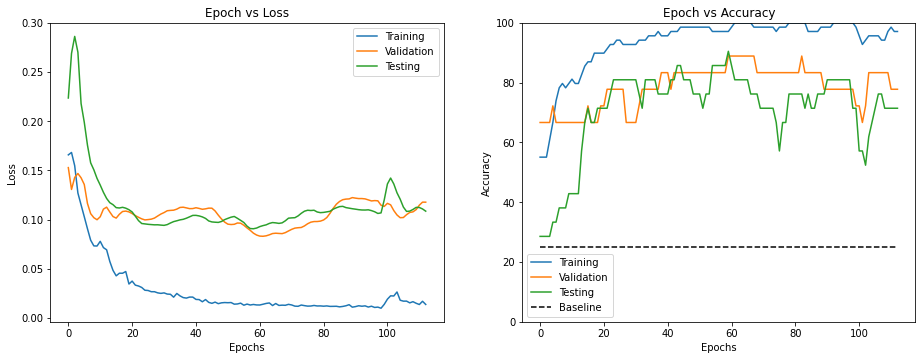

Train/Val/Test Final MSE: [0.013970373943448067, 0.08307103724736306, 0.09390508159551592]
Train/Val/Test Maximum Accuracy: [100.0, 88.88888888888889, 80.95238095238095]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07798263877630233 0.10639447228620863 0.1299500609969809
Train/Val/TEST Accuracy: 88.40579710144928 50.0 52.38095238095238
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.034058261662721634 0.09898683363119037 0.1261331997146564
Train/Val/TEST Accuracy: 92.7536231884058 61.111111111111114 47.61904761904762
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.02429196760058403 0.09647026617959556 0.11612542004634936
Train/Val/TEST Accuracy: 94.20289855072464 66.66666666666667 66.66666666666667
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.017654941137880086 0.09503337691744997 0.11152034698586379
Train/Val/TEST Accuracy: 94.20289855072464 72.22222222222223 71.42857142857143
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.014707103744149208 0.10747480276040733 0.10079740590992428
Train/Val/TEST Accuracy: 98.55072463768116 72.22222222222223 71.42857142857143
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.017650284618139268 0.10037762407834332 0.09763246473102342
Train/Val/

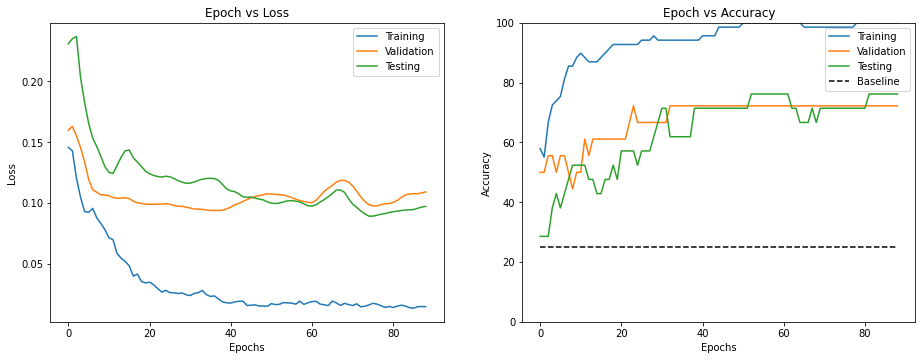

Train/Val/Test Final MSE: [0.020708009228110315, 0.09370379381450927, 0.11850647251343444]
Train/Val/Test Maximum Accuracy: [94.20289855072464, 72.22222222222223, 61.904761904761905]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.05116632431745529 0.10793173077571042 0.17483611409330652
Train/Val/TEST Accuracy: 87.14285714285714 70.58823529411765 52.38095238095238
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.02604979630559683 0.0831322418525815 0.13547145326932272
Train/Val/TEST Accuracy: 97.14285714285714 76.47058823529412 66.66666666666667
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.018256597872823476 0.08337190974613323 0.13239067203054825
Train/Val/TEST Accuracy: 98.57142857142857 70.58823529411765 71.42857142857143
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.019825627468526362 0.0872072150985546 0.12912747000033656
Train/Val/TEST Accuracy: 97.14285714285714 64.70588235294117 66.66666666666667
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.015769387781620025 0.09184130659217343 0.14970713716355108
Train/Val/TEST Accuracy: 100.0 70.58823529411765 66.66666666666667
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.013801832869648933 0.09229241262244828 0.12927217839197033
Train/Val

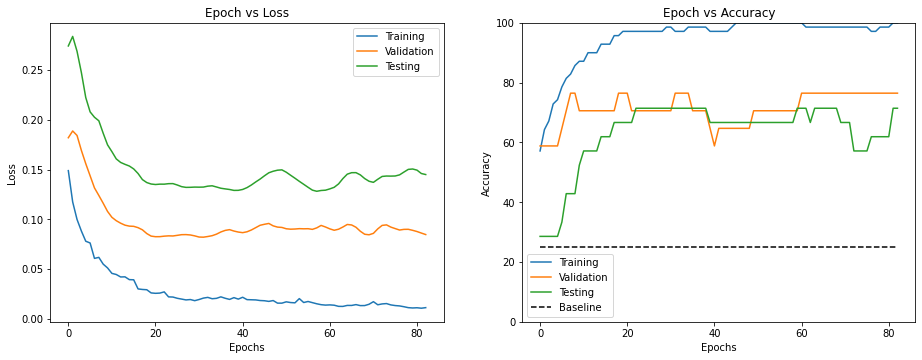

Train/Val/Test Final MSE: [0.02084847018122673, 0.0820563638528042, 0.13240714065198386]
Train/Val/Test Maximum Accuracy: [97.14285714285714, 76.47058823529412, 71.42857142857143]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07604160755872727 0.14852380336207502 0.14303343033506757
Train/Val/TEST Accuracy: 70.0 52.94117647058823 42.857142857142854
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.03398234061896801 0.1451356950599481 0.11622856470889278
Train/Val/TEST Accuracy: 87.14285714285714 47.05882352941177 42.857142857142854
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.025963477790355682 0.16755887811236522 0.12593818809199592
Train/Val/TEST Accuracy: 95.71428571428571 58.8235294117647 57.142857142857146
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.01952467132359743 0.1558081079274416 0.13477399488467545
Train/Val/TEST Accuracy: 95.71428571428571 52.94117647058823 57.142857142857146
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.017259237170219422 0.16246219760026126 0.11736092822892326
Train/Val/TEST Accuracy: 100.0 52.94117647058823 66.66666666666667
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.015412263199687004 0.14543601607575135 0.1134509249767732
Train/Val/TEST Accura

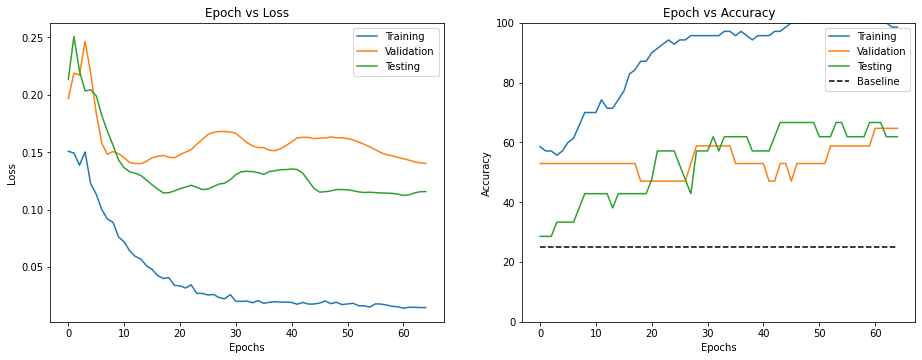

Train/Val/Test Final MSE: [0.05690724030137062, 0.13999504119376927, 0.12965065001377038]
Train/Val/Test Maximum Accuracy: [71.42857142857143, 52.94117647058823, 38.095238095238095]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09972967505455017 0.19148389973184643 0.18096022281263555
Train/Val/TEST Accuracy: 72.85714285714286 52.94117647058823 42.857142857142854
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.04493216462433338 0.14851043187081814 0.10522532267939477
Train/Val/TEST Accuracy: 90.0 70.58823529411765 57.142857142857146
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.03216068409383297 0.11332283563473645 0.12736338368129163
Train/Val/TEST Accuracy: 90.0 70.58823529411765 57.142857142857146
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.01957616414874792 0.1083804922287955 0.13828163101736987
Train/Val/TEST Accuracy: 95.71428571428571 70.58823529411765 52.38095238095238
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.015222170576453208 0.08922698436414495 0.12428121059201658
Train/Val/TEST Accuracy: 97.14285714285714 70.58823529411765 61.904761904761905
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.013523115776479244 0.08406310994178057 0.11242533076022353
Train/Val/TEST Accur

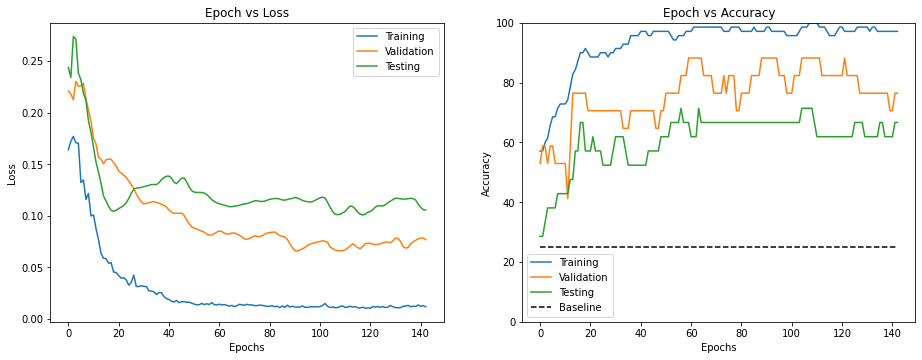

Train/Val/Test Final MSE: [0.011446097865700722, 0.06570893517859719, 0.11698257127067163]
Train/Val/Test Maximum Accuracy: [98.57142857142857, 88.23529411764706, 66.66666666666667]


In [9]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [10]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.024776038303971293, 0.09290703425740861, 0.11829038320907523]
Train/Val/Test Average Accuracy: [92.26915113871635, 75.75163398692811, 63.80952380952381]


## Single prediction results

In [13]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output, CerealTimeKillersLabels)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target, CerealTimeKillersLabels)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', flabels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.0006061 0.5330313 0.0913918 0.3261091] with label  [1]
Target Example: [0.    1.125 0.125 0.   ] with label  [1]
Real Label Example: [ 1. 10.  2.  1.] with label  [1]
------- MSE: 0.11447599530220032  Accuracy: 100.0 %-------

Batch 2  ( Size 1 ):
Output Example: [9.7095573e-01 2.9188026e-05 8.6906314e-02 4.7502127e-02] with label  [2]
Target Example: [1.125 0.    1.125 0.   ] with label  [2]
Real Label Example: [10.  1. 10.  1.] with label  [0, 2]
------- MSE: 0.27590614557266235  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.31500337 0.11966264 0.62361276 0.6010544 ] with label  [0]
Target Example: [0.875 0.    0.25  0.   ] with label  [2]
Real Label Example: [8. 1. 3. 1.] with label  [0]
------- MSE: 0.20719203352928162  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [2.0636367e-05 3.1455490e-04 7.7230853e-01 6.1587249e-03] with label  [0]
Target Example: [0.    0.    0.5   0.875] with label  [0]
Real Label Ex